# Python for Finance: Group Assignment

## ***Topic: Forex Trading Strategies with Backtesting***

### Made by: Anubhav Lal, Armin Etemi, Duncan de Wit, Jules Boudreault and Philipp Kramer.

In [1]:
!pip install pandas-datareader

In [2]:
###Import all packages
import numpy as np #to use numpy math
import pandas as pd #to work with dataframes
import csv #to handle csv files
import pandas_datareader as web #to get data from web for example CHAPTER 0
import matplotlib.pyplot as plt #to plot
import time #to use timeseries data
import datetime #to use timeseries and date data
import os #to make sure that everyone is able to run code on different OS
import sys #to solve an error which I got while loading data
import matplotlib.style #to change the plot styles to ggplot
from pandas.core.common import flatten #to collapse an array into one dimension
from functools import partial #to reduce the number of parameters in a function
from functools import reduce #to apply a function to all of the list elements

#Use ggplot style for nicer plots
plt.style.use('ggplot')

In [3]:
#Make sure that the script and excel files are in the same folder
###STEP 1: Load data
#Define path (don't forget forward instead of backward slashes) and create list for datafiles
path = '/Users/julesboudreault/Desktop/Projet'
pairs_list = []

#Iterate through path and append every .csv-file and split them by dots (.) to columns
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split(',')[0])
print(pairs_list)

['AUD to USD.csv', 'GBP to USD.csv', 'EUR to USD.csv']


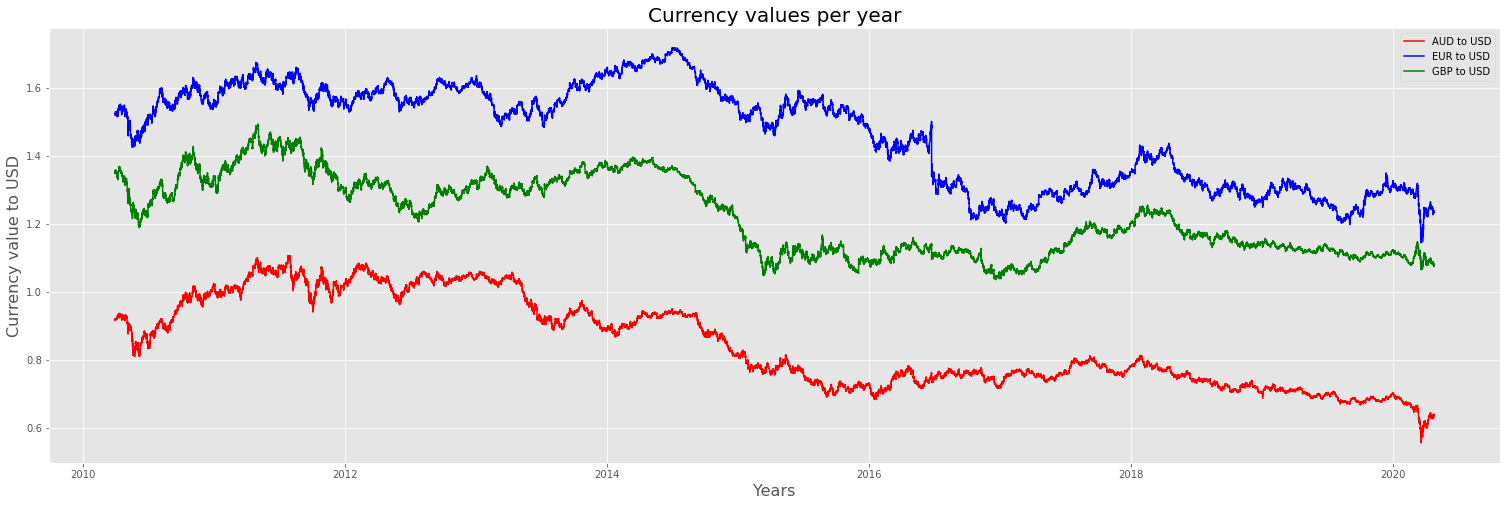

In [4]:
#Read CSV-files and create dataframe with column-names Date, Open, High, Low, Close & Volume
#! Watch out: save the data files and Jupyter notebook in the same folder for this to work
dfTrades = {}
for pair in range(len(pairs_list)):
    # ! Watch out: double check whether you have to add +'.csv' if the file name printed in pairs_list does not contain it
    dfTrades[pair] = pd.read_csv(pairs_list[pair], header = 0)
    dfTrades[pair].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    # Split Date column by space to be able to delete unnecessary data regarding GMT (3rd column)
    dfTrades[pair]['Date'] = dfTrades[pair]['Date'].str.split(' ').str[0:2]
    # Join it back by space without the GMT data
    dfTrades[pair]['Date'] = dfTrades[pair]['Date'].str.join(' ')
    # Set date-column as an index
    dfTrades[pair].set_index('Date', inplace = True)
    # Change format of datetime
    dfTrades[pair].index = pd.to_datetime(dfTrades[pair].index, format = '%d.%m.%Y %H:%M:%S.%f')
    
plt.figure(figsize = (26, 8))
plt.title('Currency values per year', fontsize=20)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Currency value to USD', fontsize=16)
plt.plot(dfTrades[0]['Close'], color = 'red', label='AUD to USD')
plt.plot(dfTrades[1]['Close'], color = 'blue', label='EUR to USD')
plt.plot(dfTrades[2]['Close'], color = 'green', label='GBP to USD')
plt.legend()
plt.show()

# Strategy 1: Simple Moving Average Crossover using Average True Range

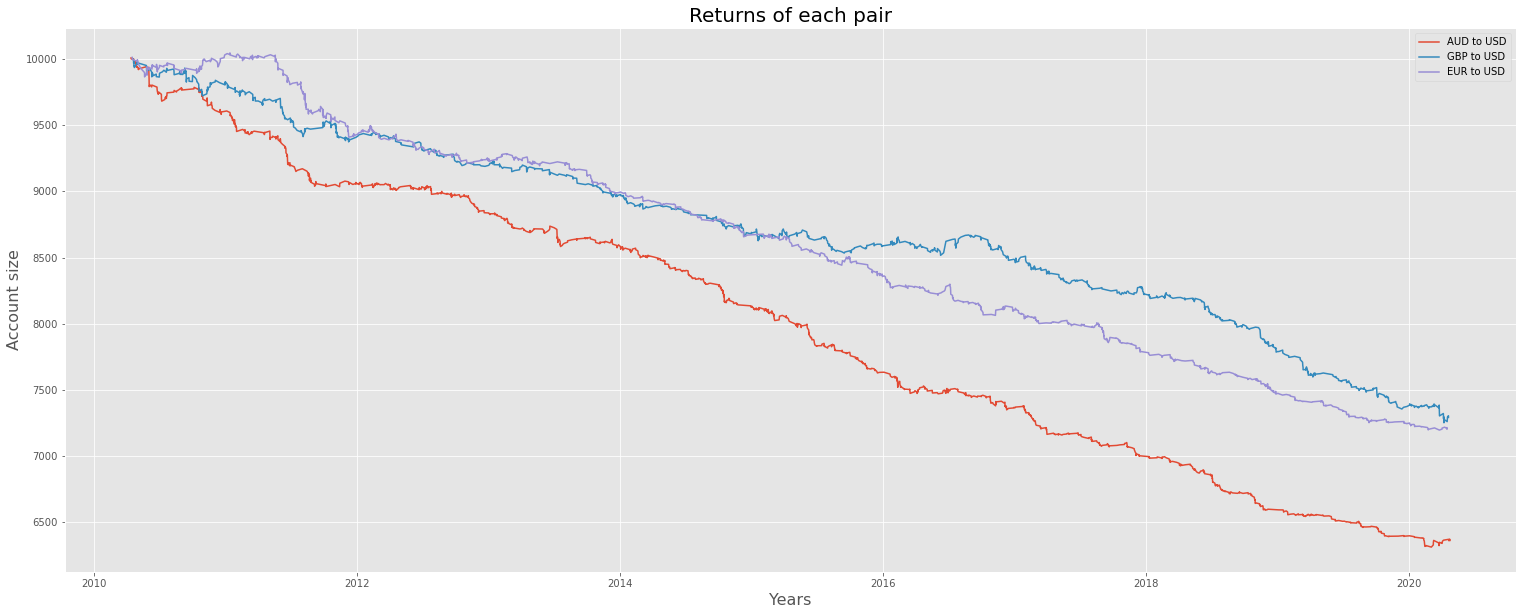

MOVING AVERAGE CROSSOVER PERFORMANCE
Number of trades: 4293
Number of profits: 1998
Number of losses: 2290
Number of breakevens: 5 

Winning percentage 46.6 %
Return On Investment: -9139
Average profitable trade: 6.95
Average lossing trade: -10.06
Maximum profitable trade: 86.71
Maximum lossing trade: -36.43


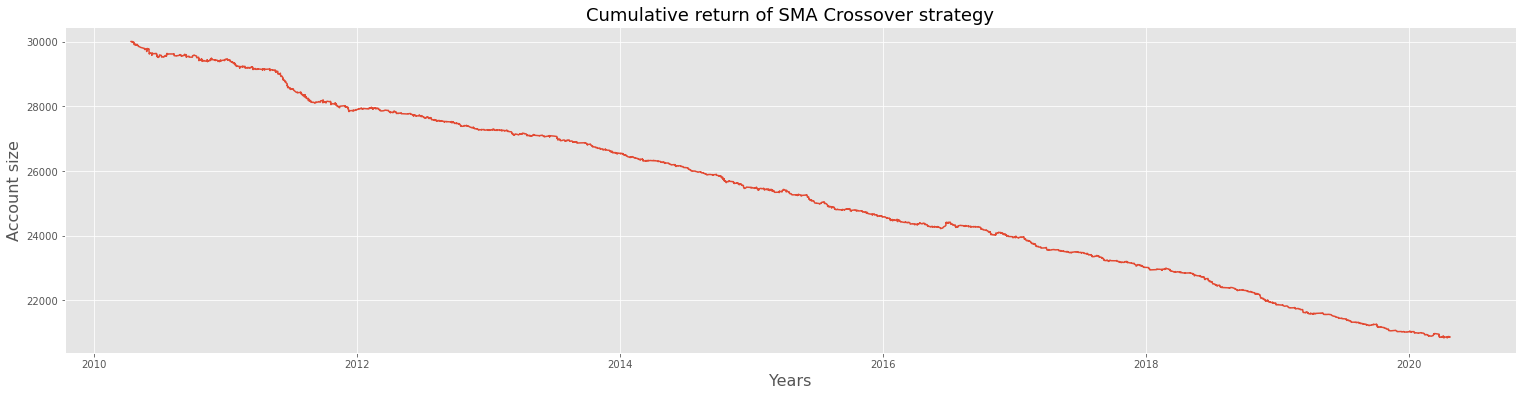

In [5]:
#Calculate fast and slow Simple Moving Average (SMA)
def SMA(dfTrades, fast, slow):
    dfTrades['SMAfast'] = dfTrades['Close'].rolling(fast).mean()
    dfTrades['SMAslow'] = dfTrades['Close'].rolling(slow).mean()
    return dfTrades

#Calculate the True Ranges (High-Low; High-Close; Low-Close) and average them
def ATR(dfTrades, n):
    #Copy dataframe
    dfTrades = dfTrades.copy()
    #Calculate High-Low
    dfTrades['High-Low'] = abs(dfTrades['High'] - dfTrades['Low'])
    #Calculate High-Close
    dfTrades['High-PrevClose'] = abs(dfTrades['High'] - dfTrades['Close'].shift(1))
    #Calculate Low-Close
    dfTrades['Low-PrevClose'] = abs(dfTrades['Low'] - dfTrades['Close'].shift(1))
    #True range = maximum value of all three ranges
    dfTrades['TrueRange'] = dfTrades[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    #Compute the average
    dfTrades['AvgTrueRange'] = dfTrades['TrueRange'].rolling(n).mean()
    #Drop the columns which we will not use anymore
    dfTrades = dfTrades.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return dfTrades

#Define the strategy parameters
#These parameters can be played with to find out different results with different inputs 
budget = 10000 #Amount of money you want to trade with
#Slippage is accounting for the possibility of a change in the price between placing order and order being executed (in basis points)
slippage = 2 
size = 1 #Size of position
ATR_SL = 0.5 #Stop/Loss variable is 0.5

#Now we populate the dataframes with necessary data
for pair in range(len(pairs_list)):
    dfTrades[pair]['AvgTrueRange'] = ATR(dfTrades[pair], 20)['AvgTrueRange'] #Calculates ATR for all the dataframes
    dfTrades[pair]['SMAfast'] = SMA(dfTrades[pair], 50, 200) #Calculates SMA for different periods of 50 and 200 days
#Now we want to accomodate for spread in size, most pairs have 5 decimal points
    dfTrades[pair]['spread'] = float(slippage) / float(10000) #5 decimal points for JPY
    dfTrades[pair]['size'] = float(size) * float(10000)
        
#Dictionaries created as we need the values for each currency pair. 
#The key will be number if each currency pair and the value will be taken from the key.
open_trade = {} 
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

#Lists created to append values when we have trades
#These lists are essential data collection points for entry and exit points
for pair in range(len(pairs_list)):
    open_trade[pair] = [] 
    trade[pair] = {} #Only this value should be a list so as to counter Index Error
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    for i in range(50, len(dfTrades[pair])):
        #Buy Trades - Strategy Entry Logic
#Basic logic -> if the previous candle of SMA for 50 days was lower than  the previous candle of SMA for 200 days
#But the current candle of SMA for 50 days is higher or equal to the current candle of SMA for 200 days
        if (dfTrades[pair]['SMAfast'][i-1] < dfTrades[pair]['SMAslow'][i-1]
        and dfTrades[pair]['SMAfast'][i] >= dfTrades[pair]['SMAslow'][i]
        and len(open_trade[pair]) == 0): #This just implies that we do not want to open 50 trades ar the same time
        #To know and (possibly show) whenever there is a new trade
            trade[pair][i] = {'ID': i,
                             'date_of_trade': dfTrades[pair].index[i],
                             'entry_price': dfTrades[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0,
                             'TP': dfTrades[pair]['Close'][i] + dfTrades[pair]['AvgTrueRange'][i] * ATR_SL,
                             'SL': dfTrades[pair]['Close'][i] - dfTrades[pair]['AvgTrueRange'][i] * ATR_SL} 
            #Result value will be updated when we close the position
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Sell Trades using similar logic
        if (dfTrades[pair]['SMAfast'][i-1] > dfTrades[pair]['SMAslow'][i-1] 
            and dfTrades[pair]['SMAfast'][i] <= dfTrades[pair]['SMAslow'][i] 
            and len(open_trade[pair]) == 0):
            #To know and (possibly show) whenever there is a new trade
            trade[pair][i] = {'ID': i,
                             'date_of_trade': dfTrades[pair].index[i],
                             'entry_price': dfTrades[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0,
                             'TP': dfTrades[pair]['Close'][i] - dfTrades[pair]['AvgTrueRange'][i] * ATR_SL,
                             'SL': dfTrades[pair]['Close'][i] + dfTrades[pair]['AvgTrueRange'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Exit trades 
        #Buy profit
        if any(y <= dfTrades[pair]['Close'][i] for y in long_take_profit[pair]): #To check if current close price is lower than the long take profit value for each pair
            for j in open_trade[pair]: #Now we check trades with result as 0 and signal as Buy
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy': #Code to check inside of the dictionary
                    if dfTrades[pair]['Close'][i] >= trade[pair][j]['TP']: #Then we check if the close value is actually greater or equal and if so, we update the result from 0 to the actual value
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        #We remove this trade from these lists as the function is not searching for these trades anymore
                        open_trade[pair].remove(j) 
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        #Logic: If close price is below for long and above for short, we exit position with loss
        if any(y >= dfTrades[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if dfTrades[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])

        #Sell profit
        #We use similar logic for sell signals
        if any(y >= dfTrades[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if dfTrades[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= dfTrades[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if dfTrades[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
#Sometimes when volatility suddenly drops, we can get stuck in positions with wider targets calculated from ATR with higher volatility
#If market is not going anywhere, we will be sitting on the position for a very long time
#So, it is a good idea to create an exit time after a particular number of hours
#Here we create a functionality after a stagnant period on the asset of 4 hours
#The below strategy will not be useful for those who have a swing strategy where they hold asset for days

        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]: 
                #Now, we check the difference between the iteration number now and the iteration number at the opening of the trade
                #When we create new trades, we have ID key in the dictionary which stores the value of iteration i (starting from 50)
                #As we have hourly data, one iteration signifies one hour
                #If the difference is more than or equal to the idle period we have set of 4 hours, we close the position
                #This strategy is extremely beneficial for intraday trading
                if ((i - trade[pair][j]['ID']) >= 4 
                and trade[pair][j].get('result', {}) == 0 
                and trade[pair][j].get('signal', {}) == 'Buy'):
                    trade[pair][j].update({'result' : (dfTrades[pair]['Close'][i] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif ((i - trade[pair][j]['ID']) >= 4 
                      and trade[pair][j].get('result', {}) == 0 
                      and trade[pair][j].get('signal', {}) == 'Sell'):
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dfTrades[pair]['Close'][i] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

#Now that we have our trading logic ready, we need to collect and analyse for each trade for each currency pair
#We create the below necessary dictionary to collect data essential for backtesting
#We split results into profit, losses and breakeven to see our strategy statistics
pairs_results = {}
profits = {}
losses = {}
breakeven = {}

#We can append these lists to the above dictionaries for the whole strategy
for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    breakeven[pair] = []

    #Creates a dataframe from a dictionary with trade ID, date of trade, entry price, signal, result, take profit and stop loss
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    #Then we drop the columns that we do not require
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    #We then set the date of trade as the index
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    #Finally, we create a column with the cumulative sum of the results
    #We append the account size to see how the strategy performs for each pair
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + budget

    #We append trade result profits, losses and breakevens based on the criteria
    #Usually, the breakeven point is not exactly zero but somewhere around 0.05 in reality
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.05 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.05 else ''
        breakeven[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.05 else ''

#Now we want to merge our results data frame into 1 dataframe
#The reduce function is used to apply a particular function passed in its argument to all of the list elements mentioned in the sequence
#The partial function derives a function with expiry, just a limited function with your parameters and fixed value set
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
#Then we merge those results dataframe into 1 dataframe
strategy_results = reduce(my_reduce, pairs_results.values())
#We sort the dataframe by index so that the trades on different pairs are in order of date and time rather than transactions grouped as per pair
strategy_results = strategy_results.sort_index()
#We create a new column which is a sum of each column
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
#We create a final column with a cumulative sum with the account size for results for each pair
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + budget

#Putting all profits, losses and breakevens together
#They are sorted as dictionaries with keys are currency pair numbers and values as actual results
#First we grab the keys from the dictionary and store as a list
profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys] #Using list comprehension
#Using the pandas flatten function helps return the copy of the array collapsed into one dimension
#Now we store the profit values as a flattened list
str_profits = list(flatten(profits_values))

#Doing the same for losses and breakven
losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

breakeven_keys = list(breakeven.keys())
breakeven_values = [breakeven[x] for x in breakeven_keys]
str_breakeven = list(flatten(breakeven_values))

plt.figure(figsize = (26, 10))
#To plot line for each of the pairs
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair][0:10])
plt.title('Returns of each pair', fontsize = 20)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Account size', fontsize=16)
plt.legend()
plt.show()

#SMA Crossover Strategy statistics and results
print('MOVING AVERAGE CROSSOVER PERFORMANCE')
print('Number of trades:', len(str_profits + str_losses + str_breakeven))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_breakeven), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('Return On Investment:', round(strategy_results['cum_res'][-1]) - budget)
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Maximum profitable trade:', round(max(str_profits), 2))
print('Maximum lossing trade:', round(min(str_losses), 2))

# Graph for the cumulative
plt.figure(figsize = (26, 6))
plt.title('Cumulative return of SMA Crossover strategy', fontsize = 18)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Account size', fontsize=16)
plt.plot(strategy_results['cum_res']+2*10000) # To have a budget of 30K instead of 10K (this should be changed with more input datasets)
plt.show()

# Strategy 2: Bollinger Bands

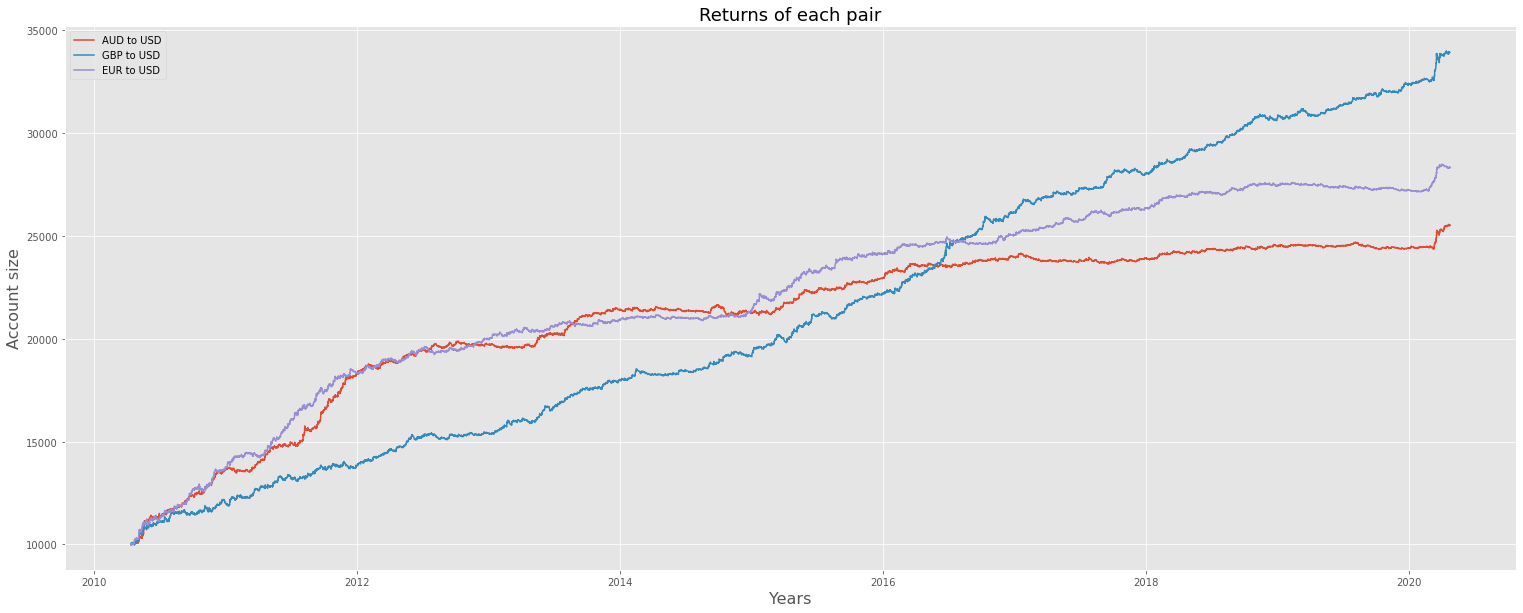

BOLLINGER BANDS PERFORMANCE
Number of trades: 35287
Number of profits: 13544
Number of losses: 21649
Number of breakevens: 94 

Winning percentage 38.48 %
Return On Investment: 57731
Average profitable trade: 19.52
Average lossing trade: -9.54
Maximum profitable trade: 231.5
Maximum lossing trade: -113.87


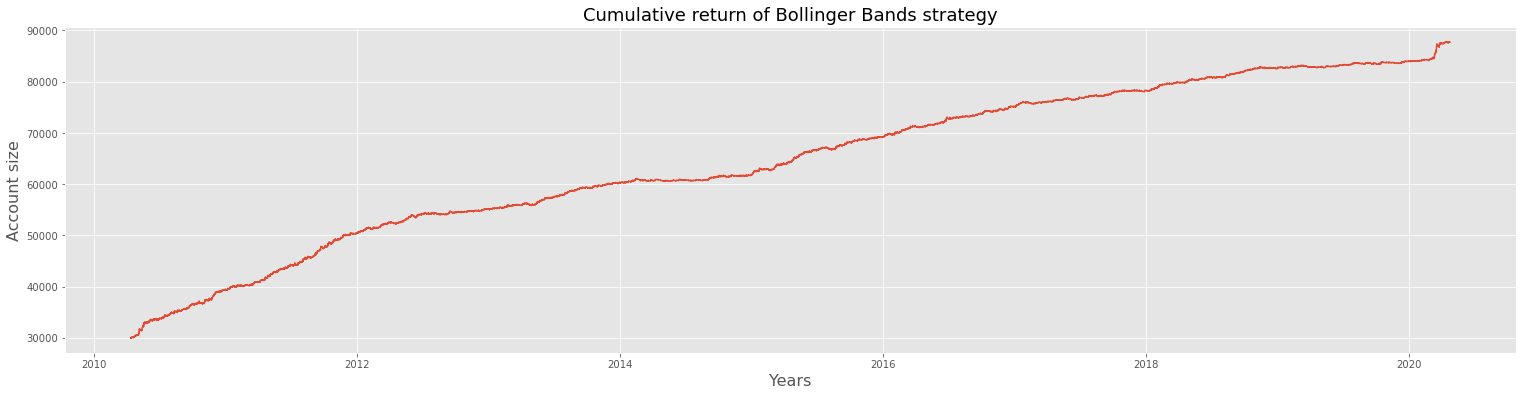

In [6]:
#Bollinger Bands consist a mean value and two bands) above and below which are mean +- standard deviation*multiplier.
#A multiplier of 3 is used in our calculation but mean+2*st.dev is also possible.
#The mean is an Simple Moving Average (SMA) in this example, but often an Exponential Moving Average (EMA) is used.
#When the prices touch the upper Bollinger band, the security would be bought too much. Therefore, we will sell.
#Likewise, when they continually touch the lower Bollinger band, the security would be sold too much. Therefore, we will buy.

def Bollinger_bands(dfTrades, window, std_mult):
    #Calculate mean of closing value
    dfTrades['rolling_mean'] = dfTrades['Close'].rolling(window).mean()
    #Calculate standard deviation of closing value
    dfTrades['rolling_std'] = dfTrades['Close'].rolling(window).std()
    #Calculate the upper band: mean + standard deviation
    dfTrades['upper_band'] = dfTrades['rolling_mean'] + (dfTrades['rolling_std'] * std_mult)
    #Calculate the lower band: mean - standard deviation
    dfTrades['lower_band'] = dfTrades['rolling_mean'] - (dfTrades['rolling_std'] * std_mult)

for pair in range(len(pairs_list)):
    #Assign average true rate as explained in previous strategy
    dfTrades[pair]['AvgTrueRange'] = ATR(dfTrades[pair], 20)['AvgTrueRange']
    #Assign fast SMA of 50 and 200 days
    dfTrades[pair]['SMAfast'] = SMA(dfTrades[pair], 50, 200)
    #Assign band values with 3 (!) standard deviations -> you can alter this number if preferred
    dfTrades[pair]['upper_band'] = Bollinger_bands(dfTrades[pair], 50, 3)
    #Define the spread
    dfTrades[pair]['spread'] = float(slippage) / float(10000)
    #Define the size
    dfTrades[pair]['size'] = float(size) * float(10000)
    
#Dictionaries created as we need the values for each currency pair. 
#The key will be number if each currency pair and the value will be taken from the key.
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    for i in range(50, len(dfTrades[pair])):
        #Buy
        #If SMA fast is greater than SMA slow and any closing value is below or equal to lower band
        if dfTrades[pair]['SMAfast'][i-1] > dfTrades[pair]['SMAslow'][i-1] and any (dfTrades[pair]['Close'][i-3: i-1].values) <= any (dfTrades[pair]['lower_band'][i-3: i-1].values) and dfTrades[pair]['Close'][i] >= dfTrades[pair]['rolling_mean'][i] and len(open_trade[pair]) == 0:
            #Some trade info for if you want to show it
            trade[pair][i] = {'ID': i,
                             'date_of_trade': dfTrades[pair].index[i],
                             'entry_price': dfTrades[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0,
                             'TP': dfTrades[pair]['Close'][i] + dfTrades[pair]['AvgTrueRange'][i] * 10 * ATR_SL,
                             'SL': dfTrades[pair]['Close'][i] - dfTrades[pair]['AvgTrueRange'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Sell
        #if SMA fast is smaller than SMA slow and any closing value is equal or bigger than upper band
        if dfTrades[pair]['SMAfast'][i-1] < dfTrades[pair]['SMAslow'][i-1] and any (dfTrades[pair]['Close'][i-3: i-1].values) >= any (dfTrades[pair]['upper_band'][i-3: i-1].values) and dfTrades[pair]['Close'][i] <= dfTrades[pair]['rolling_mean'][i] and len(open_trade[pair]) == 0:
            trade[pair][i] = {'ID': i,
                             'date_of_trade': dfTrades[pair].index[i],
                             'entry_price': dfTrades[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0,
                             'TP': dfTrades[pair]['Close'][i] - dfTrades[pair]['AvgTrueRange'][i] * 10 * ATR_SL,
                             'SL': dfTrades[pair]['Close'][i] + dfTrades[pair]['AvgTrueRange'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])

        #Exit trades
        #Buy profit
        if any(y <= dfTrades[pair]['Close'][i] for y in long_take_profit[pair]): #To check if current close price is lower than the long take profit value for each pair
            for j in open_trade[pair]: #Now we check trades with result as 0 and signal as Buy
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy': #Code to check inside of the dictionary
                    if dfTrades[pair]['Close'][i] >= trade[pair][j]['TP']: #Then we check if the close value is actually greater or equal and if so, we update the result from 0 to the actual value
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        #We remove this trade from these lists as the function is not searching for these trades anymore
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        #Logic: If close price is below for long and above for short, we exit position with loss
        if any(y >= dfTrades[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if dfTrades[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])

        #Sell profit
        #We use similar logic for sell signals
        if any(y >= dfTrades[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if dfTrades[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= dfTrades[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if dfTrades[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            #Now, we check the difference between the iteration number now and the iteration number at the opening of the trade
            #When we create new trades, we have ID key in the dictionary which stores the value of iteration i (starting from 50)
            #As we have hourly data, one iteration signifies one hour
            #If the difference is more than or equal to the idle period we have set of 4 hours, we close the position
            #This strategy is extremely beneficial for intraday trading
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 4 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (dfTrades[pair]['Close'][i] - trade[pair][j]['entry_price'] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 4 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - dfTrades[pair]['Close'][i] - dfTrades[pair]['spread'][i]) * dfTrades[pair]['size'][i]})
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    
#Now that we have our trading logic ready, we need to collect and analyse for each trade for each currency pair
#We create the below necessary dictionary to collect data essential for backtesting
#We split results into profit, losses and breakeven to see our strategy statistics
pairs_results = {}
profits = {}
losses = {}
breakeven = {}

#We can append these lists to the above dictionaries for the whole strategy
for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    breakeven[pair] = []

#Creates a dataframe from a dictionary with trade ID, date of trade, entry price, signal, result, take profit and stop loss
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    #Then we drop the columns that we do not require
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    #We then set the date of trade as the index
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    #Finally, we create a column with the cumulative sum of the results
    #We append the account size to see how the strategy performs for each pair
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + budget

    #We append trade result profits, losses and breakevens based on the criteria
    #Usually, the breakeven point is not exactly zero but somewhere around 0.05 in reality
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.05 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.05 else ''
        breakeven[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.05 else ''

#Now we want to merge our results data frame into 1 dataframe
#The reduce function is used to apply a particular function passed in its argument to all of the list elements mentioned in the sequence
#The partial function derives a function with expiry, just a limited function with your parameters and fixed value set
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
#Then we merge those results dataframe into 1 dataframe
strategy_results = reduce(my_reduce, pairs_results.values())
#We sort the dataframe by index so that the trades on different pairs are in order of date and time rather than transactions grouped as per pair
strategy_results = strategy_results.sort_index()
#We create a new column which is a sum of each column
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
#We create a final column with a cumulative sum with the account size for results for each pair
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() # + budget is excluded in the 2nd strategy since it is profitable

#Putting all profits, losses and breakevens together
#They are sorted as dictionaries with keys are currency pair numbers and values as actual results
#First we grab the keys from the dictionary and store as a list
profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys] #Using list comprehension
#Using the pandas flatten function helps return the copy of the array collapsed into one dimension
#Now we store the profit values as a flattened list
str_profits = list(flatten(profits_values))

#Doing the same for losses and breakven
losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

breakeven_keys = list(breakeven.keys())
breakeven_values = [breakeven[x] for x in breakeven_keys]
str_breakeven = list(flatten(breakeven_values))

#Plot graph per pair
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair][0:10])
plt.title('Returns of each pair', fontsize = 18)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Account size', fontsize=16)
plt.legend()
plt.show()

# Performance statistics of Bollinger Bands strategy
print('BOLLINGER BANDS PERFORMANCE')
print('Number of trades:', len(str_profits + str_losses + str_breakeven))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_breakeven), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('Return On Investment:', round(strategy_results['cum_res'][-1]))
print('Average profitable trade:', round(sum(str_profits)/len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Maximum profitable trade:', round(max(str_profits), 2))
print('Maximum lossing trade:', round(min(str_losses), 2))

# Graph for the cumulative
plt.figure(figsize = (26, 6))
plt.title('Cumulative return of Bollinger Bands strategy', fontsize = 18)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Account size', fontsize=16)
plt.plot(strategy_results['cum_res']+3*10000) # To bring budget from 10K to 30K (this should be changed if more datasets as input)
plt.show()